# Import Statements

In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import math
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import PIL
import matplotlib.pyplot as plt
import glob
import warnings
warnings.filterwarnings('ignore')
import tensorflow_addons as tfa
from tensorflow.keras.metrics import top_k_categorical_accuracy, categorical_accuracy


In [2]:
root = "D:\IIIT-D\Summer Semester\CAPSTONE PROJECT\Complete Dataset"

In [3]:
train_dir = root+'/Hair Removed Images/train'
val_dir = root+'/Hair Removed Images/val'
test_dir = root+'/Hair Removed Images/test'

# Build A Model

## Preprocessing

In [4]:
train_datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet.preprocess_input)

In [5]:
# test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_data = train_datagen.flow_from_directory(train_dir,target_size=(224,224),batch_size=32,class_mode='categorical',seed=42)

Found 40253 images belonging to 7 classes.


In [7]:
val_data = train_datagen.flow_from_directory(val_dir,target_size=(224,224),batch_size=32,class_mode='categorical',seed=42)

Found 1000 images belonging to 7 classes.


In [8]:
test_data = train_datagen.flow_from_directory(test_dir,target_size=(224,224),batch_size=32,class_mode='categorical',shuffle=False)

Found 1007 images belonging to 7 classes.


# Building The CNN

In [9]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(7,activation='softmax')(x) #final layer with softmax activation

In [10]:
model=Model(inputs=base_model.input,outputs=preds)
#specify the inputs
#specify the outputs
#now a model has been created based on our architecture

In [11]:
# for layer in model.layers:
#     layer.trainable=False
# # or if we want to set the first 20 layers of the network to be non-trainable
# for layer in model.layers[:20]:
#     layer.trainable=False
# for layer in model.layers[20:]:
#     layer.trainable=True

In [12]:
def top_2_acc(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [13]:
def top_3_acc(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [14]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [15]:
lrReduction=ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.5,
                              patience=2,
                              verbose=1,
                              mode='auto',
                              min_lr=0.00001)

In [16]:
early_stopping = EarlyStopping(monitor="val_accuracy", patience=5, verbose=1)

In [17]:
# model = tf.keras.models.load_model('D:\IIIT-D\Summer Semester\CAPSTONE PROJECT\Saved Models\Mobile_Net_83.h5',
#                                    custom_objects={'top_2_acc':top_2_acc,'top_3_acc':top_3_acc})

In [18]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy',
                                                                        top_2_acc,
                                                                        top_3_acc,
                                                                        tf.metrics.AUC(curve='ROC'),
                                                                        tfa.metrics.MatthewsCorrelationCoefficient(num_classes=7)])

In [19]:
step_size_train=train_data.n//train_data.batch_size
history = model.fit_generator(generator=train_data,
                   steps_per_epoch=step_size_train,
                   validation_data=val_data,
                    epochs=50, 
                    verbose = 1,
                    callbacks=[lrReduction,early_stopping])

Epoch 1/50
1257/1257 [==============================] - 425s 333ms/step - loss: 0.7719 - accuracy: 0.7267 - top_2_acc: 0.8752 - top_3_acc: 0.9455 - auc: 0.9496 - MatthewsCorrelationCoefficient: 0.6813 - val_loss: 0.7405 - val_accuracy: 0.7300 - val_top_2_acc: 0.9010 - val_top_3_acc: 0.9780 - val_auc: 0.9560 - val_MatthewsCorrelationCoefficient: 0.5335
Epoch 2/50
1257/1257 [==============================] - 324s 257ms/step - loss: 0.5091 - accuracy: 0.8176 - top_2_acc: 0.9361 - top_3_acc: 0.9803 - auc: 0.9770 - MatthewsCorrelationCoefficient: 0.7874 - val_loss: 0.5806 - val_accuracy: 0.7920 - val_top_2_acc: 0.9270 - val_top_3_acc: 0.9770 - val_auc: 0.9701 - val_MatthewsCorrelationCoefficient: 0.5835
Epoch 3/50
1257/1257 [==============================] - 325s 259ms/step - loss: 0.3910 - accuracy: 0.8619 - top_2_acc: 0.9578 - top_3_acc: 0.9880 - auc: 0.9856 - MatthewsCorrelationCoefficient: 0.8390 - val_loss: 0.6052 - val_accuracy: 0.7900 - val_top_2_acc: 0.9300 - val_top_3_acc: 0.9760 -

Epoch 23/50
1257/1257 [==============================] - 324s 257ms/step - loss: 0.0017 - accuracy: 0.9995 - top_2_acc: 1.0000 - top_3_acc: 1.0000 - auc: 1.0000 - MatthewsCorrelationCoefficient: 0.9994 - val_loss: 1.1507 - val_accuracy: 0.8570 - val_top_2_acc: 0.9550 - val_top_3_acc: 0.9810 - val_auc: 0.9482 - val_MatthewsCorrelationCoefficient: 0.7233
Epoch 24/50
1257/1257 [==============================] - 324s 258ms/step - loss: 0.0016 - accuracy: 0.9996 - top_2_acc: 1.0000 - top_3_acc: 1.0000 - auc: 1.0000 - MatthewsCorrelationCoefficient: 0.9996 - val_loss: 1.1976 - val_accuracy: 0.8620 - val_top_2_acc: 0.9500 - val_top_3_acc: 0.9840 - val_auc: 0.9461 - val_MatthewsCorrelationCoefficient: 0.7278

Epoch 00024: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 25/50
1257/1257 [==============================] - 324s 258ms/step - loss: 0.0011 - accuracy: 0.9996 - top_2_acc: 1.0000 - top_3_acc: 1.0000 - auc: 1.0000 - MatthewsCorrelationCoefficient: 0.9996 - val_

In [20]:
loss,accuracy,top_2,top_3,auc,mcc = model.evaluate(train_data)

1258/1258 [==============================] - 74s 58ms/step - loss: 5.1045e-06 - accuracy: 1.0000 - top_2_acc: 1.0000 - top_3_acc: 1.0000 - auc: 1.0000 - MatthewsCorrelationCoefficient: 1.0000


In [55]:
loss,accuracy,top_2,top_3,auc,mcc = model.evaluate(val_data)

32/32 [==============================] - 6s 163ms/step - loss: 1.2144 - accuracy: 0.8620 - top_2_acc: 0.9520 - top_3_acc: 0.9860 - auc: 0.9467 - MatthewsCorrelationCoefficient: 0.7289


In [21]:
loss,accuracy,top_2,top_3,auc,mcc = model.evaluate(test_data)

32/32 [==============================] - 4s 134ms/step - loss: 1.2004 - accuracy: 0.8620 - top_2_acc: 0.9553 - top_3_acc: 0.9841 - auc: 0.9479 - MatthewsCorrelationCoefficient: 0.7315


In [40]:
# model.save("D:\IIIT-D\Summer Semester\CAPSTONE PROJECT\Saved Models\Mobile_Net_Test_Acc_86_V2.h5")

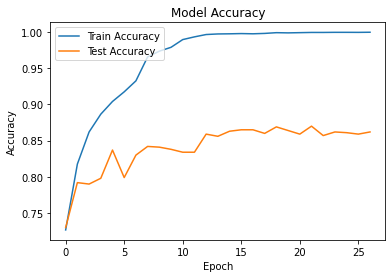

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Test Accuracy'], loc='upper left')
plt.show()

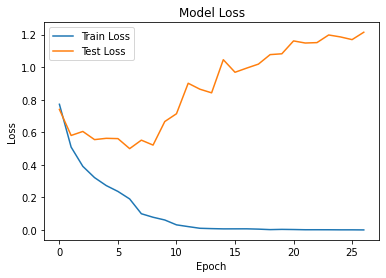

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Test Loss'], loc='upper left')
plt.show()

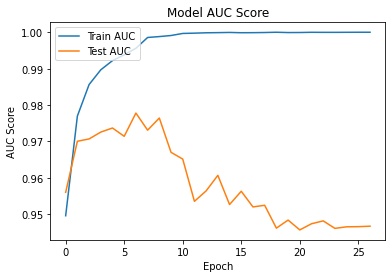

In [25]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC Score')
plt.ylabel('AUC Score')
plt.xlabel('Epoch')
plt.legend(['Train AUC', 'Test AUC'], loc='upper left')
plt.show()

In [26]:
# model.save('D:\IIIT-D\Summer Semester\CAPSTONE PROJECT\Saved Models\Mobile_Net_86.h5')

In [27]:
train_data.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [28]:
test_data.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [29]:
from sklearn import metrics

In [30]:
true_test_labels=test_data.labels

In [31]:
true_test_labels=np.array(true_test_labels)

In [32]:
np.unique(true_test_labels,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([ 34,  52, 111,  12, 112, 671,  15], dtype=int64))

In [33]:
pred_test_labels=model.predict(test_data)

In [34]:
pred_test_labels=np.argmax(pred_test_labels,axis=1)

In [35]:
metrics.accuracy_score(true_test_labels,pred_test_labels)

0.8619662363455809

In [54]:
report = metrics.classification_report(true_test_labels,pred_test_labels)
print(report)

              precision    recall  f1-score   support

           0       0.79      0.76      0.78        34
           1       0.78      0.81      0.79        52
           2       0.79      0.76      0.77       111
           3       1.00      0.67      0.80        12
           4       0.65      0.57      0.61       112
           5       0.91      0.94      0.93       671
           6       1.00      0.67      0.80        15

    accuracy                           0.86      1007
   macro avg       0.84      0.74      0.78      1007
weighted avg       0.86      0.86      0.86      1007



In [37]:
cf=metrics.confusion_matrix(true_test_labels,pred_test_labels)

In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[ 26   3   3   0   2   0   0]
 [  1  42   3   0   2   4   0]
 [  3   1  84   0   8  15   0]
 [  1   0   0   8   0   3   0]
 [  2   1   7   0  64  38   0]
 [  0   7   9   0  21 634   0]
 [  0   0   1   0   1   3  10]]


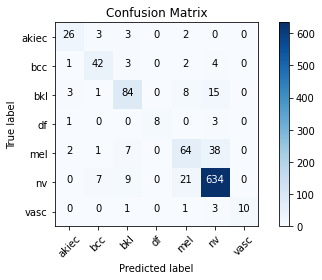

In [39]:
import itertools
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cf, cm_plot_labels, title='Confusion Matrix')

In [41]:
FP = cf.sum(axis=0) - np.diag(cf) 
FN = cf.sum(axis=1) - np.diag(cf)
TP = np.diag(cf)
TN = cf.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)

In [50]:
print(np.sum(TPR)/len(TPR))

0.7398250388331667
